In [5]:
from warnings import simplefilter

import numpy as np
import pandas as pd

from sktime.datasets import load_airline
# from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
# from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline

In [6]:
'''
Open HDF5 datafile
'''
import h5py
import geopandas as gpd
h5file = h5py.File('./processed/newdata.h5', 'r')
brazil = gpd.read_file('./data/shapefile/BR_borders/BR_MUN_WGS84.shp').GEOCODIGO.sort_values()

In [7]:
selection = h5file['VHI']['1101435']
dtstr = [i+'-01 00:00:00' for i in selection]


item = 'mean'
df = pd.Series([selection[i].attrs[item] for i in selection],
                 index = pd.to_datetime(dtstr).to_period('M'),
#                  columns = [item]
              )


df 

2019-01    36.971516
2019-02    38.577499
2019-03    42.278625
2019-04    45.330116
2019-05    52.842304
2019-06    36.748528
2019-07    36.748528
2019-08    41.850155
2019-09    39.333725
2019-10    55.539894
2019-11    50.702347
2019-12    45.828075
2020-01    37.262951
2020-02    39.336548
2020-03    39.858719
2020-04    45.011845
2020-05    42.001808
2020-06    40.217609
2020-07    45.938530
Freq: M, dtype: float64

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

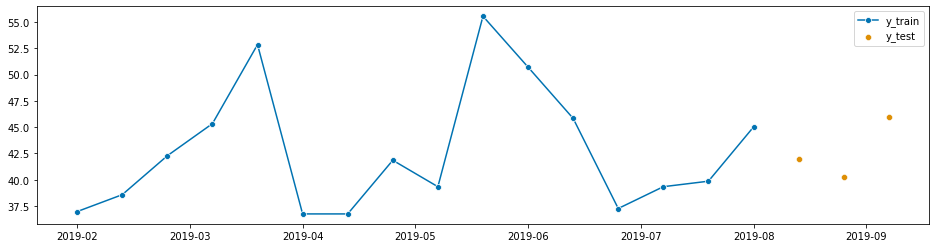

In [8]:
y_train, y_test = temporal_train_test_split(df, test_size=3)
plot_series(y_train, y_test, labels=["y_train", "y_test"])

In [13]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
smape_loss(y_test, y_pred)

ValueError: x must have 2 complete cycles requires 24 observations. x only has 16 observation(s)

ValueError: operands could not be broadcast together with shapes (16,) (3,) 

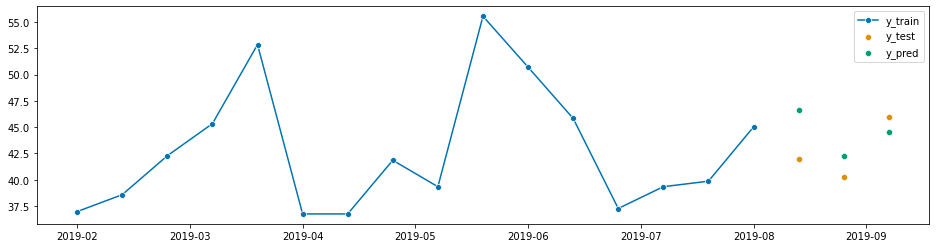

In [14]:
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();